In this tutorial, we will learn how to build a Spiking Neural Network (SNN) and directly train it via Surrogate Gradient Descent (SurrGD) method. This tutorial although fast paced, is meant for absolute beginners in SNNs, and requires a basic-to-intermediate understanding of PyTorch.

# Introduction
Spiking Neural Networks (SNNs) are architecturally similar to ANNs/DNNs, however, built with `spiking neurons` instead of the conventional `rate neurons` (i.e., ReLU, Sigmoid, etc). This way, SNNs are more biologically plausible than ANNs/DNNs.
```
Why SNNs? Because, apart from several other advantages, they are energy efficient compared to ANNs/DNNs, -- albeit on neuromorphic hardware; thus, a promising step towards Green-AI.
```
There are two common ways to build SNNs:
* ANN-to-SNN: In this method, we first train the desired ANN/DNN via regular Back-propagation based methods, followed by its conversion to an isomorphic SNN. Unfortunately, this method usually results in SNNs which have higher inference latency. My Nengo-DL tutorials: [(1)](https://r-gaurav.github.io/2021/03/07/Spiking-Neural-Nets-for-Image-Classification-in-Nengo-DL.html) and [(2)](https://r-gaurav.github.io/2021/12/31/Batchwise-Training-and-Test-of-Spiking-Neural-Networks-for-Image-Classification-in-Nengo-DL.html) cover this ANN-to-SNN approach; other libraries offering ANN-2-SNN conversion exist too, e.g., [SNN Toolbox](https://snntoolbox.readthedocs.io/en/latest/), and [Lava](https://lava-nc.org/dl.html#bootstrap) (an improvement over conventional ANN-to-SNN).

* Direct Training: In this method, we train our desired SNN natively using approaches inspired from Computational Neuroscience, Back-propagation, etc. Examples include Spike Timing Dependent Plasticity (STDP) based methods, Back-propagation Through Time (BPTT) based methods, etc. One such highly effective and popular method is BPTT-based ``Surrogate Gradient Descent'' (SurrGD), where the SNNs are trained using a surrogate-derivative function. We focus on SurrGD here and discuss it in more details later.

# Spiking Neuron

We first start with implementing a `Spiking Neuron` (to be used in our SNN), followed by the actual implementation and training of a `Dense SNN`. A spiking neuron is a **stateful** system, such that it maintains an internal `voltage` state (`v`) and outputs a discrete (usually binary) spike of magnitude $1$ whenever its `v` reaches or crosses a set `threshold` voltage (`v_thr`). Once the neuron spikes, its `v` is reset to $0$. 

From a number of spiking neuron models, most popular ones suitable for SNNs are `Integrate & Fire` (IF), and `Leaky Integrate & Fire` (LIF). I have already implemented a detailed LIF neuron model [here](https://r-gaurav.github.io/2020/05/08/From-Spiking-Neurons-To-Artificial-Neurons.html); we focus on the simple IF neuron model in this tutorial to build our SNN.

Following is the `continuous-time` equation of the IF neuron model:
$$ C\frac{dV}{dt} = I$$
and following is its `discrete-time` implementation (for computers):
$$V_{t+1} = V_{t} + I$$

## Implementation
Following is the code for implementing a single IF neuron model, whose threshold voltage (`v_thr`) is set to $1$. It accummulates/integrates the input into its `voltage` state: `v`, and generates a spike of magnitude $1$ when `v` reaches or crosses the `v_thr`; simultaneously, `v` is reset to $0$. Note that in the implementation below, I am rectifying the state `v` to $0$, in case it goes negative.

In [1]:
class IF_neuron(object):
  def __init__(self, v_thr=1.0):
    """
    Args:
      v_thr <int>: Threshold voltage of the IF neuron, default 1.0 .
    """
    self._v_thr = v_thr
    self._v = 0

  def encode_input_and_spike(self, inp):
    """
    Integrates the input and produces a spike if the IF neuron's voltage reaches 
    or crosses threshold.
    
    Args:
      inp <float>: Scalar input to the IF neuron.
    """
    self._v = self._v + inp
    if self._v >= self._v_thr:
      self._v = 0 # Reset the voltage and produce a spike.
      return 1.0 # Spike.
    elif self._v < 0: # Rectify the voltage if it is negative.
      self._v = 0 

    return 0 # No spike.

### Executing the IF neuron

In [2]:
# Import necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from nengo_extras.plot_spikes import plot_spikes

In [3]:
# Create one spiking neuron and encode a random input signal.
if_neuron = IF_neuron(v_thr=1) # Instantiate a neuron.
T = 100 # Set the duration of input signal in time-steps.
inp_signal = 2*(0.5 - np.random.rand(T)) # Generate signal.

spikes = []
for t in range(T): # Execute the IF neuron for the entire duration of the input.
  spikes.append(if_neuron.encode_input_and_spike(inp_signal[t]))
spikes = np.array(spikes).reshape(-1, 1)

### Plotting the input and generated spikes

(0.0, 100.0)

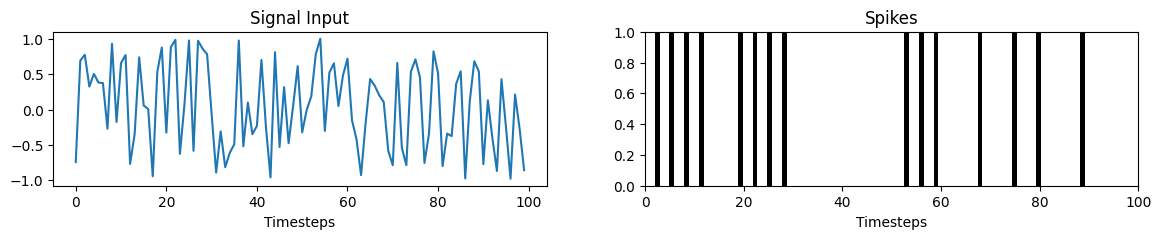

In [4]:
plt.figure(figsize=(14, 2))
plt.subplot(1, 2, 1)
plt.plot(inp_signal)
plt.title("Signal Input")
plt.xlabel("Timesteps");
plt.subplot(1, 2, 2)
plt.title("Spikes")
plot_spikes(np.arange(0, T), spikes)
plt.xlabel("Timesteps");
plt.xlim([0, 100])

# Dense SNN

Now that we have implemented a single IF neuron -- the fundamental unit of an SNN, we next focus on building and training a Dense-SNN (SNN composed of `Dense` layers only) from scratch. The architecture here consists of an input `Encoder` layer, followed by (arbitrarily chosen) two spiking `Hidden` layers and a final `Output` layer. We will use the MNIST dataset, which will be flattened for the input to our SNN. The `Encoder` layer `rate` encodes the normalized pixel values to binary spikes, upon which, the `Dense` connections in the `Hidden` layers learn the feature maps. The `Dense` connections in the `Output` layer learn the classication over the feature map via the `CrossEntropyLoss` function. 

## Implementation
For convenience and uniformity of spiking layers in our SNN, I first implement the `BaseSpkNeuron` class, which can be inherited by the spiking `Encoder`, `Hidden`, and `Output` layers. The `Output` layer consists of spiking units equal to the number of classes. The mean of the output spike trains (over simulation time-steps) is passed to the loss function. I begin by importing the necessary libraries and defining the network constants:

In [5]:
import torch
from abc import abstractmethod
import numpy as np

V_THR = 1.0
DEVICE = "cpu" # Change it to "cuda" if you have an NVIDIA-GPU.
BATCH_SIZE = 500 # Change it to suit your memory availability.
TAU_CUR = 1e-3 # Time constant of current decay.

### BaseSpkNeuron class

This class implements the basic template of IF spiking neurons arranged in vector/matrix form. It will be inherited by other classes, which implement the Encoding and Spiking-Hidden layers.

In [6]:
class BaseSpkNeuron(object):
  def __init__(self, n_neurons):
    """
    Args:
      n_neurons: Number of spiking neurons.
      v_thr <int>: Threshold voltage.
    """
    self._v = torch.zeros(BATCH_SIZE, n_neurons, device=DEVICE)
    self._v_thr = torch.as_tensor(V_THR)

  def update_voltage(self, c):
    """
    Args:
      c <float>: Current input to update the voltage.
    """
    self._v = self._v + c
    mask = self._v < 0 # Mask to rectify the voltage if negative.
    self._v[mask] = 0

  def reinitialize_voltage(self):
    """
    Resets all the neurons' voltage to zero.
    """
    self._v = torch.zeros_like(self._v)

  @abstractmethod
  def spike_and_reset_voltage(self):
    """
    Abstract method to be mandatorily implemented for the neuron to spike and 
    reset the voltage.
    """
    raise NotImplementedError

In the above class definition, note that all the child classes implement the spiking function as the **Heaviside step-function**, i.e., $\Theta (x) = 1$ if $x>=0$ else $0$. Since this spiking neuron function $\Theta$ is discontinuous and non-differentiable at $x=0$, (i.e., the derivative of $\Theta(x)$ is the ill-defined Dirac's $\delta$ function), Back-propagation based methods are not natively applicable. Note that the derivative $\Theta^\prime(x)$ is $0$ everywhere except at $x=0$ where it is undefined. Thus, when applying Back-prop natively, the error-gradients either vanish or explode, rendering the training of weights infeasible. To alleviate this gradient vanishing/exploding problem, one needs to approximate the $\delta$ function (i.e., $\Theta^\prime(x)$) via a `surrogate-derivative` function, explained below.

## Surrogate Spike-Derivative
The concept of using a Surrogate Spike-Derivative in place of the ill-defined $\frac{d\Theta(x)}{dx}$ has been explored by a number of researchers to train the SNNs directly. Here I use the the partial derivative of the fast sigmoid function $f(x) = \frac{x}{(1 + |x|)}$, i.e., $f^\prime(x) = \frac{1}{(1+|x|)^2}$ as $\Theta^\prime(x)$ (as used by [F. Zenke](https://github.com/fzenke/spytorch/tree/main/notebooks) -- basis of this tutorial). The figure below shows the plot of $f(x)$ in blue, and of $f^\prime(x)$ in red. As can be observed, $f^\prime(x)$ isn't $0$ everywhere and is maximum $1$ at $x=0$. Replacing the ill-defined $\Theta^\prime(x)$ with $f^\prime(x)$ and using it in conjunction with Back-prop to natively train the SNNs is called the Surrogate Gradient Descent method -- as made popular by [F. Zenke](https://scholar.google.com/citations?user=_IxvO8QAAAAJ&hl=en&oi=ao) and [E. Neftci](https://scholar.google.com/citations?user=yYT6jtkAAAAJ&hl=en&oi=ao). 

Below is the code which enables the use of `surrogate-derivatives` while training the SNNs via BPTT.

In [7]:
class SrgtDrtvSpike(torch.autograd.Function):
  """
  This class implements the spiking function for the forward pass along with its
  surrogate-derivative in the backward pass.
  """
  scale = 100

  @staticmethod
  def forward(ctx, x):
    """
    Computes the spikes and returns it.

    Args:
      ctx: is the context object.
      x: is the input of the spiking function - Heaviside step function. The input
        to this function should be `v(t) - v_thr`, i.e. S(v(t)) = H(v(t) - v_thr).
    """
    ctx.save_for_backward(x)
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

  @staticmethod
  def backward(ctx, grad_output):
    """
    Computes the local gradient to be propagated back. Note that the local
    gradient = gradient of the forward function * grad_output. Here the forward
    function is estimated as the fast sigmoid function: x/(1+|x|), whose gradient
    is 1/((1+|x|)^2).

    Args:
      ctx: is the context object whose stored values would be used to calculate
        local gradient.
      grad_output: is the gradient output received from the previous layer.
    """
    x, = ctx.saved_tensors
    grad_input = grad_output.clone()
    local_grad = grad_output * 1.0/((1.0 + torch.abs(x)*SGSpike.scale)**2)
    return local_grad

spike_func = SrgtDrtvSpike.apply

## Spiking Layers
Following are the implementations of the individual types of spiking layers in my Dense-SNN:

### SpkEncoderLayer class

This class encodes the normalized pixel values to spikes via **Rate-Encoding**, where the number of output spikes is proportional to the magnitude of the pixel value. An encoding neuron does this by implementing the equation: $$J = \alpha \times x + \beta$$ where $\alpha$ and $\beta$ are the neuron's `gain` value and `bias` value; $x$ is the neuron's input.

In [8]:
class SpkEncoderLayer(BaseSpkNeuron):
  def __init__(self, n_neurons, gain=1.0, bias=0.0):
    """
    Args:
      n_neurons: Number of spiking neurons.
      gain <int>: Gain value of the neuron.
      bias <int>: Bias value of the neuron.
    """
    super().__init__(n_neurons)
    self._gain = gain
    self._bias = bias

  def spike_and_reset_voltage(self):
    delta_v = self._v - self._v_thr
    spikes = delta_v > 0
    self._v[spikes.detach()] = 0

    return spikes

  def encode(self, x_t):
    J = self._gain * x_t + self._bias
    self.update_voltage(J)
    spikes = self.spike_and_reset_voltage()

    return spikes

### SpkHiddenLayer class

This class implements the hidden layer of IF spiking neurons. Note that to enable synaptic-weight learning in the hidden layers, I am using the function `spike_func` defined above; which not only generates spikes in the forward pass but also  facilitates error back-propagation via surrogate-derivatives.

In [9]:
class SpkHiddenLayer(BaseSpkNeuron, torch.nn.Module):
  def __init__(self, n_prev, n_hidn, dt=1e-3):
    """
    Args:
      n_prev <int>: Number of neurons in the previous layer.
      n_hidn <int>: Number of neurons in this hidden layer.
      dt <float>: Delta t to determine the current decay constant.
    """
    BaseSpkNeuron.__init__(self, n_hidn)
    torch.nn.Module.__init__(self)
    self._c = torch.zeros(BATCH_SIZE, n_hidn, device=DEVICE)
    self._c_decay = torch.as_tensor(np.exp(-dt/TAU_CUR))
    self._fc = torch.nn.Linear(n_prev, n_hidn, bias=False)
    self._fc.weight.data = torch.empty(
        n_hidn, n_prev, device=DEVICE).normal_(mean=0, std=2/np.sqrt(n_prev))

  def re_initialize_neuron_states(self):
    self.re_initialize_voltage()
    self._c = torch.zeros_like(self._c)

  def spike_and_reset_voltage(self): # Implement the abstract method.
    delta_v = self._v - self._v_thr
    spikes = spike_func(delta_v)
    self._v[spikes.detach] = 0 

    return spikes

  def forward(self, x_t):
    x_t = self._fc(x_t)
    self._c = self._c_decay*self._c + x_t
    self.update_voltage(self._c)
    spikes = self.spike_and_reset_voltage()

    return spikes

### SpkOutputLayer class

This class is exactly the same as the `SpkHiddenLayer` class with the number of neurons set to the number of classes in the dataset.

In [10]:
class SpkOutputLayer(SpkHiddenLayer):
  def __init__(self, n_prev, n_otp=10):
    """
    Args:
      n_prev <int>: Number of neurons in the previous layer.
      n_otp <int>: Number of classes in the output layer (or the dataset).
    """
    super().__init__(n_prev, n_otp)

# Training and Evaluation

We now directly train and evaluate our SNN on the MNIST data. Since the SNN here is a `Dense-SNN`, with the input `SpkEncoderLayer` being a flat spiking layer, I flatten the MNIST images before feeding them to the SNN. Then I use the `Adam` optimizer to train the `Dense-SNN` via BPTT -- i.e., internally, PyTorch unrolls the `Dense-SNN` in time and the propagates the error-gradients). The loss is defined on the mean firing rates of the `SpkOutputLayer` class neurons, using the Negative Log Likelihood loss function.